In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.15.0'

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

In [4]:
train_data.shape

(45000, 32, 32, 3)

In [5]:
train_data = train_data / 255.
train_data = train_data.reshape([-1, 32, 32, 3])
train_data = train_data.astype(np.float32)
train_labels = train_labels.reshape([-1])
train_labels = train_labels.astype(np.int32)

valid_data = valid_data / 255.
valid_data = valid_data.reshape([-1, 32, 32, 3])
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.reshape([-1])
valid_labels = valid_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape([-1, 32, 32, 3])
test_data = test_data.astype(np.float32)
test_labels = test_labels.reshape([-1])
test_labels = test_labels.astype(np.int32)


In [6]:
print(train_data.shape, train_labels.shape)

(45000, 32, 32, 3) (45000,)


In [7]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [30]:
batch_size = 32
max_epochs = 20

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for valid
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


label = 1


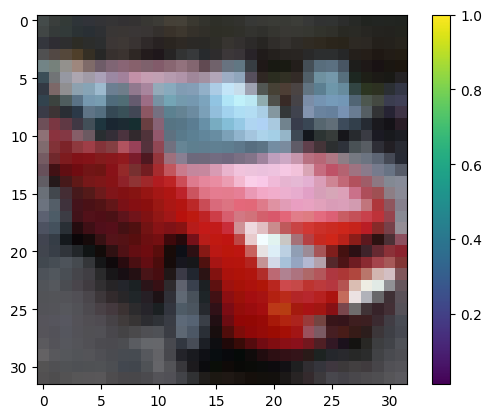

In [31]:
index = 655
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(32, 32, 3))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

### MODELS
* Input [b, 32, 32, 3]
* Conv2D 32, 3 -> Conv-Conv-Pool
* Conv2D 64, 3 -> Conv-Conv-Pool
* Conv2D 128, 3 -> Conv-Conv-Pool
* Dense 128
* Dense 64
* Dense 32
* output layers

In [32]:
model = tf.keras.Sequential()

In [33]:
inputs = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, 3, strides=1, padding='same')(inputs) # b, 32, 32, 32
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, 3, strides=1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x_skip = layers.MaxPool2D()(x) # b, 16, 16, 32

x = layers.Conv2D(64, 3, strides=1, padding='same')(x_skip) # b, 16, 16, 64
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 3, strides=1, padding='same')(x)
x = layers.BatchNormalization()(x) # b, 16, 16, 64

x = tf.concat([x, x_skip], -1) # b, 16, 16, 64 + 32

x = layers.Activation('relu')(x)
x = layers.MaxPool2D()(x) # b, 8, 8, 96

x = layers.Flatten()(x) # b, 8*8*96

x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [34]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[0.09666118 0.08786812 0.10943801 0.10035786 0.0990692  0.08853884
  0.09296235 0.11062039 0.11821526 0.09626884]]


In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 32, 32, 32)           896       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_16 (Ba  (None, 32, 32, 32)           128       ['conv2d_16[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 32, 32, 32)           0         ['batch_normalization_16

In [37]:
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    steps_per_epoch=train_data.shape[0] / batch_size,
                    epochs=max_epochs,
                    validation_data=valid_dataset,
                    validation_steps=valid_data.shape[0] / batch_size)

# 전체 데이터 갯수 / 배치 사이즈 = steps 수

Epoch 1/20
1406/1406 [==============================] - 13s 7ms/step - loss: 1.4548 - accuracy: 0.4809 - val_loss: 1.2575 - val_accuracy: 0.5550
Epoch 2/20
1406/1406 [==============================] - 11s 8ms/step - loss: 1.0936 - accuracy: 0.6121 - val_loss: 1.0395 - val_accuracy: 0.6436
Epoch 3/20
1406/1406 [==============================] - 10s 7ms/step - loss: 0.9251 - accuracy: 0.6741 - val_loss: 0.9344 - val_accuracy: 0.6684
Epoch 4/20
1406/1406 [==============================] - 10s 7ms/step - loss: 0.8149 - accuracy: 0.7150 - val_loss: 0.9009 - val_accuracy: 0.6862
Epoch 5/20
1406/1406 [==============================] - 10s 7ms/step - loss: 0.7334 - accuracy: 0.7426 - val_loss: 0.8962 - val_accuracy: 0.6960
Epoch 6/20
1406/1406 [==============================] - 11s 8ms/step - loss: 0.6667 - accuracy: 0.7667 - val_loss: 0.8548 - val_accuracy: 0.7006
Epoch 7/20
1406/1406 [==============================] - 11s 8ms/step - loss: 0.6014 - accuracy: 0.7918 - val_loss: 0.8427 - val_ac

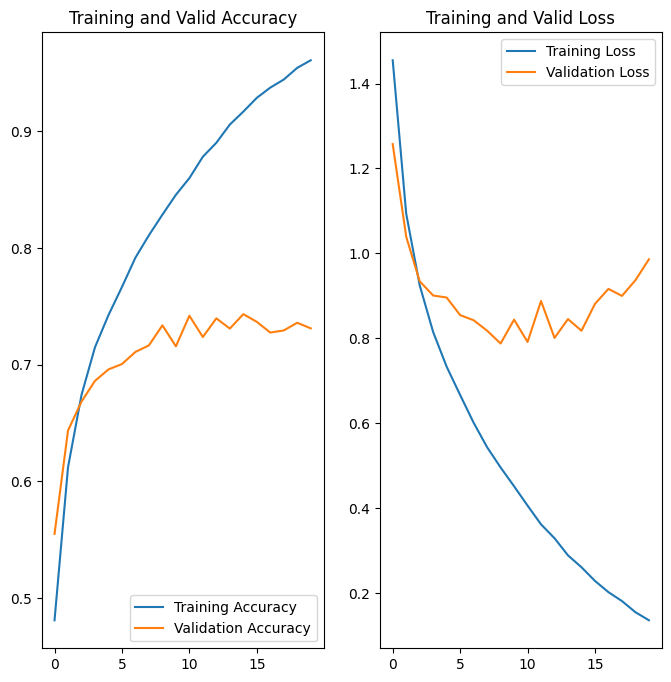

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [39]:
results = model.evaluate(test_dataset, steps=len(test_data) // batch_size)

312/312 [==============================] - 1s 4ms/step - loss: 1.0295 - accuracy: 0.7312


In [40]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 1.030
accuracy value: 73.1170%


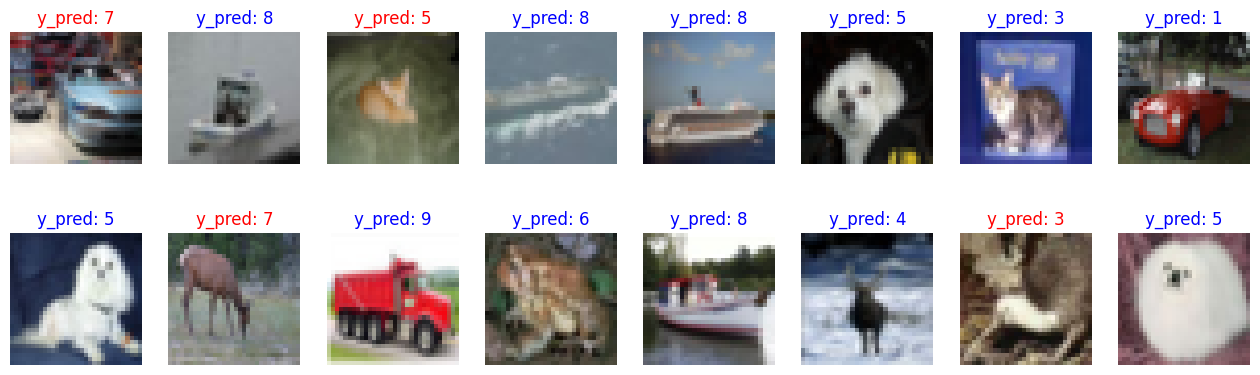

In [41]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(32, 32, 3))
  p.axis('off')